# Análisis de programas de gobierno Perú
- Limpieza y estructuración de una base de datos útil.
- Información descriptiva.
- Modelo de tópicos.

In [1]:
# Espacio de trabajo
import tqdm
import numpy as np
from numpy.random import seed
from numpy.random import randint
#import lda2vec as l2v
!pip install PyPDF2
import PyPDF2
import gensim
from gensim import corpora, similarities, models
from gensim.models.phrases import Phraser
#from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import seaborn
    from spacy_spanish_lemmatizer import SpacyCustomLemmatizer
except:
    pass
import sys
import pandas as pd
import spacy
import string
import wordcloud
import nltk
import os
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint
import re
import logging
import pyLDAvis
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOSE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Pre-procesamiento de los datos

In [66]:
path = r'C:\Users\usuario\Desktop\Programas de Gobierno'
programas = list()
for i in os.listdir(path):
    if i.endswith(".pdf"):
        programa = PyPDF2.PdfReader(path + "/" + i)
        number_of_pages = len(programa.pages)
        for i in range(number_of_pages):
            text = programa.pages[i].extract_text()
            programas.append(text)
programas

C:\Users\usuario\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['  \n PLAN DE GOBIERNO REGIÓN AREQUIPA 2023 -2026 – ROHEL SÁNCHEZ SÁNCHEZ  \n \n89 Ilustración 1. Megatendencias gl obales.  \n \n                                           Fuente : CEPLAN. Observatorio de prospectiva . \n \nEnvejecimiento de la población.  \nA nivel mundial, la densidad poblacional y la estructura etaria apuntan a cambios sin precedentes \nen las nuevas formas de vida de la población. El envejecimiento de la población seguirá teniendo \nun crecimiento sostenido en el tiempo producto del aumento de la esperanza de vida al nacer y \nde la reducción de la tasa de natalidad.  El mundo estará compuesto por una gran cantidad de \npersonas envejecidas; pese a que, en el periodo 2019 -2021, con la COVID -19, se incrementó la \ntasa de mortalidad y morbilidad en la población de 65 años a más a nivel mundial.  Según el último \ncenso (2017), l a población del grupo de 65 años  a más  se incre mentó en las últimas dos décadas , \n7,4% en el 2007 y 8,8% en el 2017.  \n \nRápida 

In [83]:
# Limpieza
programas=[re.sub(r"/(\r\n|\n|\r)/gm", "", x) for x in programas]
programas=[re.sub(r'([^0-9a-zA-Z])\1+', r'\1', x) for x in programas]
programas=[re.sub(r'^[^0-9a-zA-Z@#]+', '', x) for x in programas]
programas=[re.sub(r'()\1+', r'\1\1', x) for x in programas]
programas=[re.sub(r'(.)\1+', r'\1\1', x) for x in programas]
programas=[re.sub(r'([A-Z a-z]+)\1+', r'\1\1', x) for x in programas]
programas=[re.sub(r"(?<=[a-z])\r?\n"," ", x) for x in programas]
programas=[re.sub(r"\n", " ", x) for x in programas]
programas=[re.sub(r'[0-9]+', '', x) for x in programas]
programas=[re.sub(r'[^\w\s]', '', x) for x in programas]
programas=[re.sub(r'(?:^| )\w(?:$| )', '', x) for x in programas]
programas=[x.lower() for x in programas]
spanish_stopwords=stopwords.words('spanish')
spanish_stopwords.extend(['las','los','si','sí','de','lo','la','una'])
spanish_stopwords.extend(list(string.ascii_lowercase))
programas = [word for word in programas if not word in spanish_stopwords]
programas=[x.strip() for x in programas]
programas=[re.sub(' +', ' ', x) for x in programas]
programas

C:\Users\usuario\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['plan de gobierno región arequipa rohel sánchez sánchez ilustración megatendencias gl obales fuente ceplan observatorio de prospectiva envejecimiento de la población nivel mundial la densidad poblacionalla estructura etaria apuntancambios sin precedentes en las nuevas formas de vida de la población el envejecimiento de la población seguirá teniendo un crecimiento sostenido en el tiempo producto del aumento de la esperanza de vida al nacer de la reducción de la tasa de natalidad el mundo estará compuesto por una gran cantidad de personas envejecidas peseque en el periodo con la covid se incrementó la tasa de mortalidadmorbilidad en la población de añosmásnivel mundial según el último censopoblación del grupo de añosmás se incre mentó en las últimas dos décadas en el en el rápida urbanización global en el futuro la urbanizaciónnivel mundial será parte de los cambios sin precedentes en las nuevas formas de vida de la población habrá un crecimiento exp ansivo respectola urbanización globa

In [84]:
programas_migracion = list()
for i in range(len(programas)):
    text = programas[i]
    expresion = re.search(r"(?:[a-zA-Z'-]+[^a-zA-Z'-]+){0,10}migra(\w+)(?:[^a-zA-Z'-]+[a-zA-Z'-]+){0,10}", text)
    try:
        programas_migracion.append(expresion.group())
    except:
        try:
            expresion_2 = re.search(r"(?:[a-zA-Z'-]+[^a-zA-Z'-]+){0,10}extran(\w+)(?:[^a-zA-Z'-]+[a-zA-Z'-]+){0,10}", text)
            programas_migracion.append(expresion_2.group())
        except:
            try:
                expresion_3 = re.search(r"(?:[a-zA-Z'-]+[^a-zA-Z'-]+){0,10}refugia(\w+)(?:[^a-zA-Z'-]+[a-zA-Z'-]+){0,10}", text)
                programas_migracion.append(expresion_3.group())
            except:
                try:
                    expresion_4 = re.search(r"(?:[a-zA-Z'-]+[^a-zA-Z'-]+){0,10}venez(\w+)(?:[^a-zA-Z'-]+[a-zA-Z'-]+){0,10}", text)
                    programas_migracion.append(expresion_4.group())
                except:
                    programas_migracion.append('No match')
programas_migracion

C:\Users\usuario\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['No match',
 'las preferencias de la poblaciónprobablemente muchos de ellos decidan migrar zonas alejadas de la ciudada zonas suburbanas grandes asequibles creci',
 'graciasque desarrolla una economía urbana del sector terciario las migraciones las invasionesla concentración demográfica en las zonas urbanas',
 'ambos años obtendremos un total de nuevos estudiantes que migraron ese año de las instituciones particulareslas instituciones públicas',
 'extranjeros residentes en el país en especial de los j',
 'correspondecasos de dengue considerados graves sin embargoon el proceso de migración existente en el perú poblaciones de la región amaz',
 'demuestra que chiclayo se ha ido por el proceso de migración en una metrópoli de más de habitantes en',
 'No match',
 'No match',
 'de seguridad los colegioprofesionales los taxistas los comerciantes ambulanteslos ciudadanos extranjeros que viven en las zonas de lima metropolitana con cada',
 'indiferenciapoco involucramiento en la lucha contra l

In [86]:
programas_migracion = [x for x in programas_migracion if not 'No match' in x]
programas_migracion

C:\Users\usuario\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['las preferencias de la poblaciónprobablemente muchos de ellos decidan migrar zonas alejadas de la ciudada zonas suburbanas grandes asequibles creci',
 'graciasque desarrolla una economía urbana del sector terciario las migraciones las invasionesla concentración demográfica en las zonas urbanas',
 'ambos años obtendremos un total de nuevos estudiantes que migraron ese año de las instituciones particulareslas instituciones públicas',
 'extranjeros residentes en el país en especial de los j',
 'correspondecasos de dengue considerados graves sin embargoon el proceso de migración existente en el perú poblaciones de la región amaz',
 'demuestra que chiclayo se ha ido por el proceso de migración en una metrópoli de más de habitantes en',
 'de seguridad los colegioprofesionales los taxistas los comerciantes ambulanteslos ciudadanos extranjeros que viven en las zonas de lima metropolitana con cada',
 'indiferenciapoco involucramiento en la lucha contra la delincuencia de ciudadanos extranjero

In [89]:
with open('programas_migracion.txt', 'w') as f:
    for item in programas_migracion:
        # write each item on a new line
        f.write("%s\n," % item)
    print('Done')

Done


C:\Users\usuario\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
with open('programas_migracion.txt') as f:
    lines = f.read().splitlines()
lines

C:\Users\usuario\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['las preferencias de la población probablemente muchos de ellos decidan migrar zonas alejadas de la ciudada zonas suburbanas grandes asequibles crecimiento',
 'gracias que desarrolla una economía urbana del sector terciario las migraciones las invasiones la concentración demográfica en las zonas urbanas',
 'ambos años obtendremos un total de nuevos estudiantes que migraron ese año de las instituciones particulares las instituciones públicas',
 'extranjeros residentes en el país en especial de los',
 'corresponde casos de dengue considerados graves sin embargo el proceso de migración existente en el perú poblaciones de la región amazonía',
 'demuestra que chiclayo se ha ido por el proceso de migración en una metrópoli de más de habitantes en',
 'de seguridad los colegio profesionales los taxistas los comerciantes ambulantes los ciudadanos extranjeros que viven en las zonas de lima metropolitana con cada',
 'indiferencia poco involucramiento en la lucha contra la delincuencia de ciudada

In [96]:
programas_migracion = list()
stopwords = ['el', 'la', 'las', 'de', 'los', 'cual', 'se', 'ha', 'en', 'un','que']
for item in lines:
    querywords = item.split()
    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    result = ' '.join(resultwords)
    programas_migracion.append(result)
programas_migracion

C:\Users\usuario\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['preferencias población probablemente muchos ellos decidan migrar zonas alejadas ciudada zonas suburbanas grandes asequibles crecimiento',
 'gracias desarrolla una economía urbana del sector terciario migraciones invasiones concentración demográfica zonas urbanas',
 'ambos años obtendremos total nuevos estudiantes migraron ese año instituciones particulares instituciones públicas',
 'extranjeros residentes país especial',
 'corresponde casos dengue considerados graves sin embargo proceso migración existente perú poblaciones región amazonía',
 'demuestra chiclayo ido por proceso migración una metrópoli más habitantes',
 'seguridad colegio profesionales taxistas comerciantes ambulantes ciudadanos extranjeros viven zonas lima metropolitana con cada',
 'indiferencia poco involucramiento lucha contra delincuencia ciudadanos extranjeros residentes lima integrarlos ciudadanos extranjeros radican lima',
 'extranjeros necesitamos involucramiento todos vecinos esa manera',
 'últimos años produj

In [98]:
with open('programas_migracion_clean.txt', 'w') as f:
    for item in programas_migracion:
        # write each item on a new line
        f.write("%s\n" % item)
    print('Done')

Done


C:\Users\usuario\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
with open('programas_migracion_clean.txt') as f:
    programas_migracion = f.read().splitlines()
programas_migracion

['preferencias población probablemente muchos ellos decidan migrar zonas alejadas ciudada zonas suburbanas grandes asequibles crecimiento',
 'gracias desarrolla una economía urbana del sector terciario migraciones invasiones concentración demográfica zonas urbanas',
 'ambos años obtendremos total nuevos estudiantes migraron ese año instituciones particulares instituciones públicas',
 'extranjeros residentes país especial',
 'corresponde casos dengue considerados graves sin embargo proceso migración existente perú poblaciones región amazonía',
 'demuestra chiclayo ido por proceso migración una metrópoli más habitantes',
 'seguridad colegio profesionales taxistas comerciantes ambulantes ciudadanos extranjeros viven zonas lima metropolitana con cada',
 'indiferencia poco involucramiento lucha contra delincuencia ciudadanos extranjeros residentes lima integrarlos ciudadanos extranjeros radican lima',
 'extranjeros necesitamos involucramiento todos vecinos esa manera',
 'últimos años produj

In [3]:
# Le decimos a spaCy que vamos con toda
#spacy.prefer_gpu()
#spacy.require_gpu()
# Corremos los datos en el core de español
#nlp = spacy.load("es_core_news_sm", exclude=["ner", "parser"])
nlp = spacy.load("es_dep_news_trf", exclude=["ner", "parser","lemmatizer"])
lemmatizer_spa = SpacyCustomLemmatizer()
nlp.add_pipe("spanish_lemmatizer", name = 'lemmatizer', after = 'attribute_ruler')
#nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
#Vemos cuales son los componentes del pipeline
print(nlp.pipe_names)
#Aplicamos el pipe a cada objeto de nuestra lista de tweets
print('---------SPACY-----------')
%time docs = list(nlp.pipe(programas_migracion))

['transformer', 'morphologizer', 'attribute_ruler', 'lemmatizer']
---------SPACY-----------
Wall time: 5.69 s


In [7]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = programas_migracion
data_words = list(sent_to_words(data))


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
spanish_stopwords=stopwords.words('spanish')
spanish_stopwords.remove('no')
special_characters = "áéóíú"
#Result = [Number ** 2 for list in Numbers for Number in list if Number %2 == 0]
# Example: $tackoverflow
for palabra in spanish_stopwords:
    for letra in palabra:
        if letra in special_characters:
            escogida = palabra
            # Convertir la palabra a sin tilde
            if letra == 'á':
                nueva_palabra = escogida.replace(letra, 'a')
            elif letra == 'é':
                nueva_palabra = escogida.replace(letra, 'e')
            elif letra == 'í':
                nueva_palabra = escogida.replace(letra, 'i')
            elif letra == 'ó':
                nueva_palabra = escogida.replace(letra, 'o')
            else:
                nueva_palabra = escogida.replace(letra, 'u')
            spanish_stopwords.append(nueva_palabra)
spanish_stopwords.extend(['solo','sólo','así','asi','si','sí','pa','and','re','ser','haber','ta','va','pq','PQ','ser', 'haber'])
spanish_stopwords = set(spanish_stopwords)
spanish_stopwords = list(spanish_stopwords)
def process_words(texts, stop_words=spanish_stopwords):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("es_dep_news_trf", exclude=["ner", "parser", "lemmatizer"])
    lemmatizer_spa = SpacyCustomLemmatizer()
    nlp.add_pipe("spanish_lemmatizer", name = 'lemmatizer', after = 'attribute_ruler')
    print(nlp.pipe_names)
    docs = list()
    palabras_unir = ['mismo', 'hacer', 'no']
    for sent in texts:
        # Hay dos casos: 
        for pos in range(len(sent)):
            if sent[pos] in palabras_unir:
                # La palabra está al final
                if pos == len(sent) - 1:
                    sent[pos] = "_".join([sent[pos-1],sent[pos]])
                    sent[pos-1] = ''
                # La palabra está en la mitad 
                else:
                    sent[pos] = "_".join([sent[pos],sent[pos+1]])
                    sent[pos+1] = ''
        doc = " ".join(sent)
        docs.append(doc)
    spacy_docs = list()
    for doc in tqdm.tqdm(nlp.pipe(docs), total=len(docs)):
        texts_out.append([token.lemma_ for token in doc])
    texts_out = [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in spanish_stopwords] for doc in texts_out]
    return texts_out
data_ready = process_words(data_words)
print(data_ready)
# Create Dictionary
dictionary = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in data_ready]

<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
C:\Users\JOSE\AppData\Local\Temp/ipykernel_11308/2343856920.py:3: DeprecationWarning: invalid escape sequence \S
  sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
C:\Users\JOSE\AppData\Local\Temp/ipykernel_11308/2343856920.py:4: DeprecationWarning: invalid escape sequence \s
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


['transformer', 'morphologizer', 'attribute_ruler', 'lemmatizer']


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  4.14it/s]

[['preferencia', 'poblacion', 'probablemente', 'decidir', 'migrar', 'zona', 'alejado', 'ciudada', 'zona', 'suburbano', 'grande', 'asequible', 'crecimiento'], ['gracia', 'desarrollar', 'economia', 'urbana', 'sector', 'terciario', 'migración', 'invasión', 'concentracion', 'demografica', 'zona', 'urbanas'], ['ambos', 'ano', 'obtener', 'total', 'nuevo', 'estudiante', 'migrar', 'ano', 'institución', 'particular', 'institución', 'publicas'], ['extranjeros', 'residente', 'pais', 'especial'], ['corresponder', 'caso', 'dengue', 'considerado', 'grave', 'embargo', 'proceso', 'migracion', 'existente', 'peru', 'población', 'region', 'amazonia'], ['demostrar', 'chiclayo', 'ido', 'proceso', 'migracion', 'metropoli', 'habitante'], ['seguridad', 'colegio', 'profesionales', 'taxista', 'comerciante', 'ambulante', 'ciudadano', 'extranjeros', 'vivir', 'zona', 'lima', 'metropolitana', 'cada'], ['indiferencia', 'involucramiento', 'lucha', 'delincuencia', 'ciudadano', 'extranjeros', 'residente', 'lima', 'inte

In [8]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus]

[[('alejado', 1),
  ('asequible', 1),
  ('ciudada', 1),
  ('crecimiento', 1),
  ('decidir', 1),
  ('grande', 1),
  ('migrar', 1),
  ('poblacion', 1),
  ('preferencia', 1),
  ('probablemente', 1),
  ('suburbano', 1),
  ('zona', 2)],
 [('zona', 1),
  ('concentracion', 1),
  ('demografica', 1),
  ('desarrollar', 1),
  ('economia', 1),
  ('gracia', 1),
  ('invasión', 1),
  ('migración', 1),
  ('sector', 1),
  ('terciario', 1),
  ('urbana', 1),
  ('urbanas', 1)],
 [('migrar', 1),
  ('ambos', 1),
  ('ano', 2),
  ('estudiante', 1),
  ('institución', 2),
  ('nuevo', 1),
  ('obtener', 1),
  ('particular', 1),
  ('publicas', 1),
  ('total', 1)],
 [('especial', 1), ('extranjeros', 1), ('pais', 1), ('residente', 1)],
 [('amazonia', 1),
  ('caso', 1),
  ('considerado', 1),
  ('corresponder', 1),
  ('dengue', 1),
  ('embargo', 1),
  ('existente', 1),
  ('grave', 1),
  ('migracion', 1),
  ('peru', 1),
  ('población', 1),
  ('proceso', 1),
  ('region', 1)],
 [('migracion', 1),
  ('proceso', 1),
  ('ch

In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=num_topics, update_every=0, passes=10, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary.keys()))
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
def compute_coherence_perplexity_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           workers=7)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=dictionary, coherence='c_v')
    
    return (coherence_model_lda.get_coherence(),lda_model.log_perplexity(corpus))
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplexity': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    (cv, pp) = compute_coherence_perplexity_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    model_results['Perplexity'].append(pp)
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 540/540 [29:34<00:00,  3.29s/it]


In [11]:
tabla_tunning = pd.read_csv('lda_tuning_results.csv')
tabla_tunning = tabla_tunning.sort_values(by = 'Coherence')
tabla_tunning

,Validation_Set,Topics,Alpha,Beta,Coherence,Perplexity
72,75% Corpus,4,0.61,0.61,0.169079,-5.505316
42,75% Corpus,3,0.61,0.61,0.190569,-5.448922
77,75% Corpus,4,0.9099999999999999,0.61,0.191406,-5.554465
76,75% Corpus,4,0.9099999999999999,0.31,0.192722,-5.659410
79,75% Corpus,4,0.9099999999999999,symmetric,0.194553,-5.696176
...,...,...,...,...,...,...
275,100% Corpus,2,0.31,0.01,0.519926,-7.489952
498,100% Corpus,9,0.9099999999999999,0.9099999999999999,0.522304,-5.946503
528,100% Corpus,10,0.9099999999999999,0.9099999999999999,0.522473,-5.973440
272,100% Corpus,2,0.01,0.61,0.525074,-5.301079


In [12]:
#corpus = corpora.MmCorpus('tweets_x.mm')
#dictionary = corpora.Dictionary('tweets_x.dict')
# EL mejor modelo

lda_final_model = gensim.models.LdaMulticore(corpus=corpus,
                                             id2word=dictionary,
                                             num_topics=2,
                                             random_state=100,
                                             chunksize=100,
                                             passes=30,
                                             alpha=0.01,
                                             eta=0.61,
                                             workers=7)

[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

pprint(lda_final_model.print_topics())
doc_lda = lda_final_model[corpus]

visxx = pyLDAvis.gensim_models.prepare(topic_model=lda_final_model, corpus=corpus, dictionary=dictionary)
pyLDAvis.save_html(visxx, 'ldax_coherence.html')
pyLDAvis.display(visxx)

[(0,
  '0.029*"extranjeros" + 0.029*"migracion" + 0.014*"ciudad" + '
  '0.014*"procedimiento" + 0.014*"persona" + 0.014*"necesitar" + 0.014*"peru" '
  '+ 0.014*"proceso" + 0.014*"llegar" + 0.008*"lima"'),
 (1,
  '0.029*"extranjeros" + 0.024*"migracion" + 0.024*"ciudadano" + 0.020*"zona" '
  '+ 0.016*"ano" + 0.016*"incremento" + 0.016*"inseguridad" + 0.016*"lima" + '
  '0.011*"generar" + 0.011*"distorsionar"')]


C:\Users\JOSE\anaconda3\envs\nltkenv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [13]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

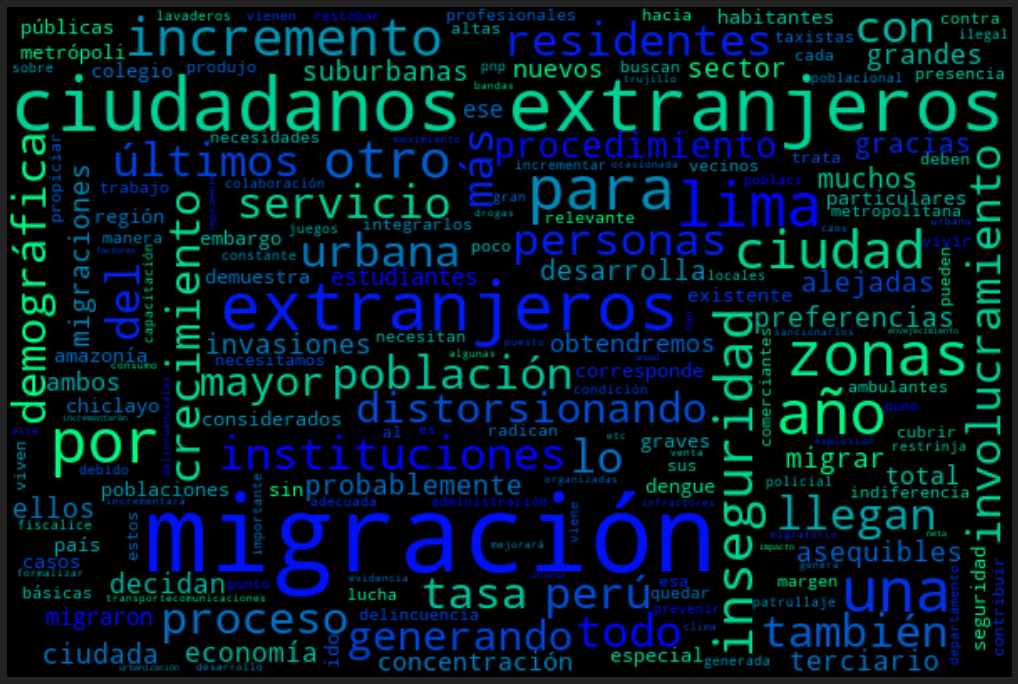

In [19]:
cloud=WordCloud(colormap="winter",width=600,height=400).generate(" ".join(programas_migracion))
fig=plt.figure(figsize=(18,15))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [20]:
def format_topics_sentences(ldamodel, corpus, texts, processed):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    processed1 = pd.Series(processed)
    sent_topics_df = pd.concat([sent_topics_df, contents, processed1], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_final_model, corpus=corpus, texts=programas_migracion, processed = data_ready)
# data_ready  df['Snippet']

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Processed']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Processed
0,0,1.0,0.9992,"extranjeros, migracion, ciudadano, zona, ano, ...",preferencias población probablemente muchos el...,"[preferencia, poblacion, probablemente, decidi..."
1,1,1.0,0.9992,"extranjeros, migracion, ciudadano, zona, ano, ...",gracias desarrolla una economía urbana del sec...,"[gracia, desarrollar, economia, urbana, sector..."
2,2,1.0,0.9992,"extranjeros, migracion, ciudadano, zona, ano, ...",ambos años obtendremos total nuevos estudiante...,"[ambos, ano, obtener, total, nuevo, estudiante..."
3,3,0.0,0.9975,"extranjeros, migracion, ciudad, procedimiento,...",extranjeros residentes país especial,"[extranjeros, residente, pais, especial]"
4,4,0.0,0.9992,"extranjeros, migracion, ciudad, procedimiento,...",corresponde casos dengue considerados graves s...,"[corresponder, caso, dengue, considerado, grav..."
5,5,0.0,0.9986,"extranjeros, migracion, ciudad, procedimiento,...",demuestra chiclayo ido por proceso migración u...,"[demostrar, chiclayo, ido, proceso, migracion,..."
6,6,1.0,0.9992,"extranjeros, migracion, ciudadano, zona, ano, ...",seguridad colegio profesionales taxistas comer...,"[seguridad, colegio, profesionales, taxista, c..."
7,7,1.0,0.9992,"extranjeros, migracion, ciudadano, zona, ano, ...",indiferencia poco involucramiento lucha contra...,"[indiferencia, involucramiento, lucha, delincu..."
8,8,0.0,0.9980,"extranjeros, migracion, ciudad, procedimiento,...",extranjeros necesitamos involucramiento todos ...,"[extranjeros, necesitar, involucramiento, veci..."
9,9,0.0,0.9988,"extranjeros, migracion, ciudad, procedimiento,...",últimos años produjo una migración relevante p...,"[ultimos, ano, producir, migracion, relevante,..."


In [21]:
df_dominant_topic.to_csv('Topico_dominante_por_frase_programa_peru.csv')

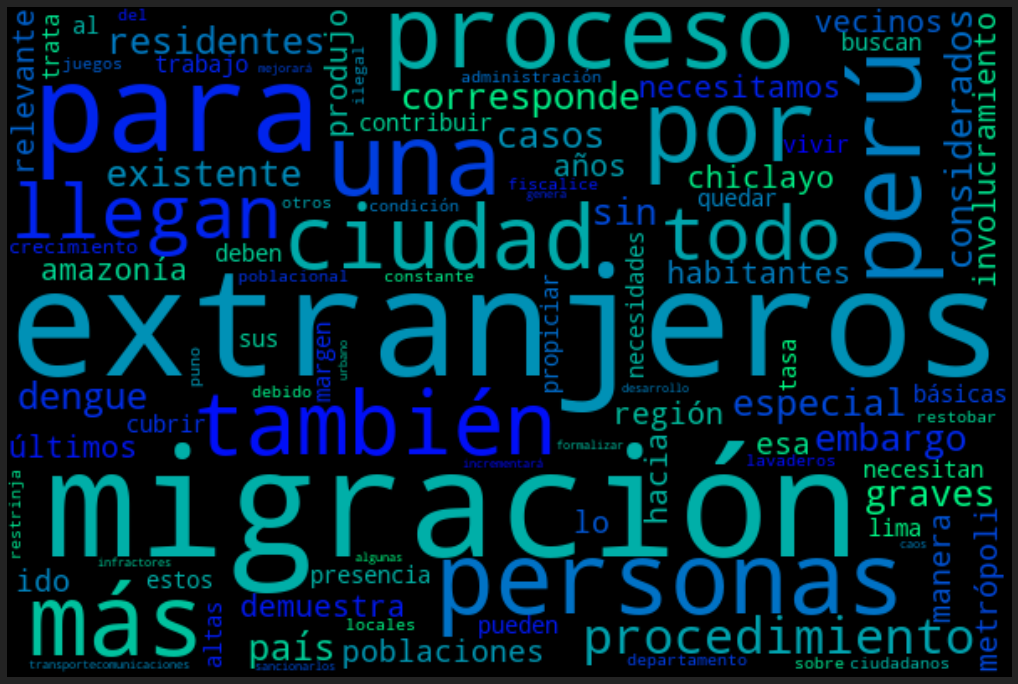

In [24]:
df_topic_0 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0.0]
cloud=WordCloud(colormap="winter",width=600,height=400).generate(' '.join(df_topic_0['Text']))
fig=plt.figure(figsize=(18,15))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

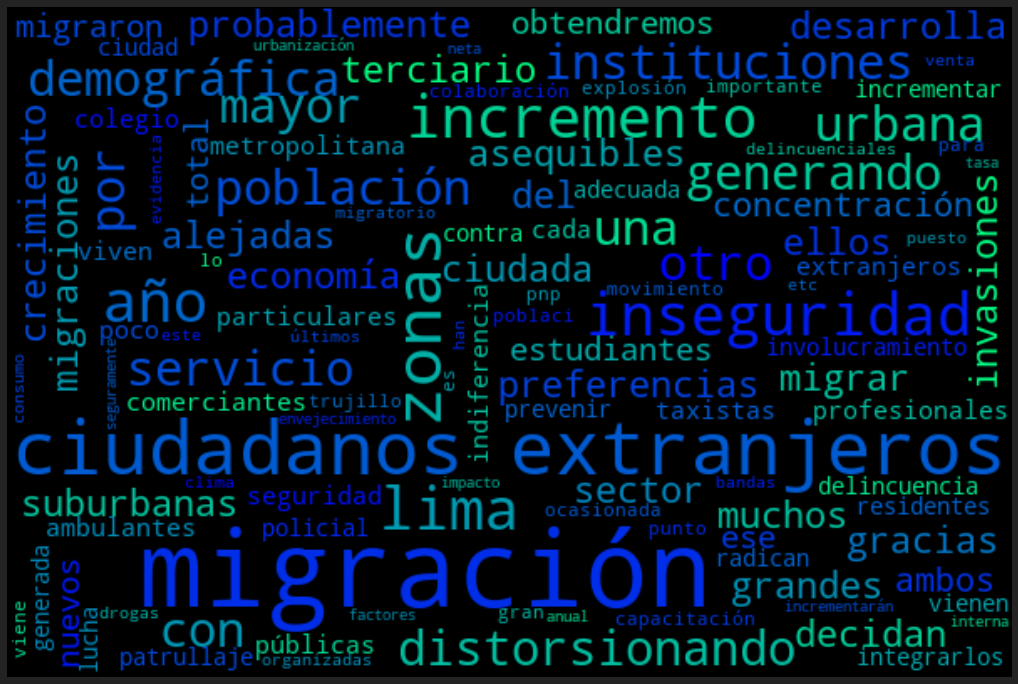

In [26]:
df_topic_1 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1.0]
cloud=WordCloud(colormap="winter",width=600,height=400).generate(' '.join(df_topic_1['Text']))
fig=plt.figure(figsize=(18,15))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')